In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from bayes_opt import BayesianOptimization
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from imblearn.over_sampling import SMOTE

os.chdir("D:/MS in DAEN/GMU 2020/CS 504/Group Delta")
print("Current Path: " + os.getcwd())

print("Reading file: ", "combine_data_with_labels_new.csv")
df = pd.read_csv('combine_data_with_labels_new.csv')

#Select independent variables 
data = df[['HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
           'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 
           'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindSpeed']]

Current Path: D:\MS in DAEN\GMU 2020\CS 504\Group Delta
Reading file:  combine_data_with_labels_new.csv


In [2]:
#Calculate the total records of each variable in Label1 -> Show the imbalance in the dataset
ontime_count, delay_count= df['Label1'].value_counts()
print(ontime_count, delay_count)

1680751 39656


In [4]:
#Choose Label3 as the target for prediction and encode the target values to numeric types. 
#Create an additional dictionary storing the inital target values mapped with encoded values.
le = preprocessing.LabelEncoder()
le.fit(df['Label1'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('\n Inital target values mapped with encoded values: \n',le_name_mapping)

df['Label1'] = le.fit_transform(df['Label1'])

#split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(data, df.Label1, test_size=0.2, random_state=0)

#Handling the imbalance in the dataset by duplicating the minorities in the training dataset
smote = SMOTE('not majority')
x_sm, y_sm = smote.fit_sample(x_train, y_train)

#convert training and test sets into DMatrices 
train = xgb.DMatrix(x_sm, label=y_sm)
test = xgb.DMatrix(x_test, label=y_test)


 Inital target values mapped with encoded values: 
 {'delay': 0, 'ontime': 1}


c:\users\hoai-anh nguyen\appdata\local\programs\python\python38\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [5]:
#Set the initial parameters to begin with
param = {
    'max_depth':14,
    'min_child_weight':1,
    'subsample': 0.969,
    'colsample_bytree': 0.833,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic'}
num_round = 180

print('\nInitial Hyperparameters for model training: \n', param, '\nThe number of rounds for boosting: ', num_round)

print('Start training model')
model = xgb.train(param, train, num_round, evals=[(test, "Test")], early_stopping_rounds=10)
print('Finish training model')


Initial Hyperparameters for model training: 
 {'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.969, 'colsample_bytree': 0.833, 'eval_metric': 'logloss', 'objective': 'binary:logistic'} 
The number of rounds for boosting:  180
Start training model
[0]	Test-logloss:0.50209
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.39123
[2]	Test-logloss:0.32059
[3]	Test-logloss:0.27081
[4]	Test-logloss:0.23106
[5]	Test-logloss:0.20337
[6]	Test-logloss:0.18243
[7]	Test-logloss:0.16746
[8]	Test-logloss:0.15527
[9]	Test-logloss:0.14385
[10]	Test-logloss:0.13598
[11]	Test-logloss:0.12961
[12]	Test-logloss:0.12324
[13]	Test-logloss:0.11841
[14]	Test-logloss:0.11460
[15]	Test-logloss:0.11024
[16]	Test-logloss:0.10823
[17]	Test-logloss:0.10550
[18]	Test-logloss:0.10153
[19]	Test-logloss:0.09969
[20]	Test-logloss:0.09861
[21]	Test-logloss:0.09602
[22]	Test-logloss:0.09260
[23]	Test-logloss:0.09044
[24]	Test-logloss:0.08995
[25]	Test-logloss:0.08702
[26]	Test-logloss:0

In [7]:
print("Best mlogloss: {:.5f} with {} rounds".format(model.best_score, model.best_iteration+1))

Best mlogloss: 0.05818 with 136 rounds


In [8]:
print('Start prediction')
predictions = model.predict(test)
print('Finish prediction')
print('Accuracy Score:', accuracy_score(y_test,predictions.round()))

Start prediction
Finish prediction
Accuracy Score: 0.9837480600554519



*Classification Report:
               precision    recall  f1-score   support

       delay       0.62      0.75      0.68      7887
      ontime       0.99      0.99      0.99    336195

    accuracy                           0.98    344082
   macro avg       0.81      0.87      0.84    344082
weighted avg       0.99      0.98      0.98    344082



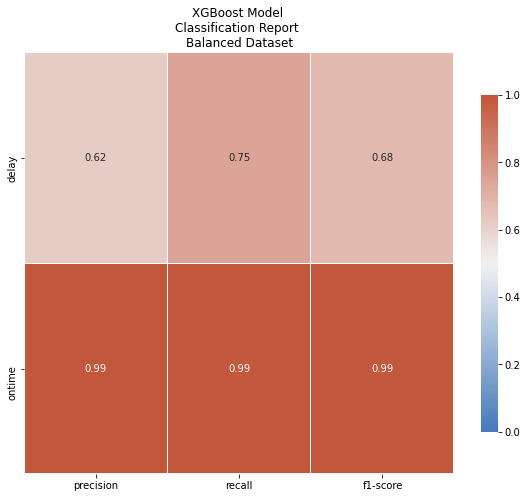

In [9]:
class_report = classification_report(y_test, predictions.round(), 
                                     target_names=['delay', 'ontime'])
print ('\n*Classification Report:\n', class_report)
# Plot heatmap for Classification Report
report = classification_report(y_test, predictions.round(), target_names=['delay', 'ontime'], 
                                     output_dict = True)
rp = pd.DataFrame(report).transpose()

rp = rp.iloc[:2,:3]

cmap = sb.diverging_palette(250, 20, as_cmap=True)
plt.subplots(figsize=(8, 8)) 
heat_map = sb.heatmap(rp, cmap=cmap, annot=True, vmax=1, vmin=0, center=0.5, 
                      square=False, linewidths=.3, cbar_kws={"shrink": .8})
heat_map.figure.tight_layout()
heat_map.figure.subplots_adjust(bottom = 0.25)
plt.title('XGBoost Model \nClassification Report \nBalanced Dataset')
plt.show()

In [10]:
cm = confusion_matrix(y_test, predictions.round())
print('\nConfusion Matrix: \n', cm)


Confusion Matrix: 
 [[  5914   1973]
 [  3619 332576]]


           delay    ontime
delay   0.749842  0.250158
ontime  0.010765  0.989235


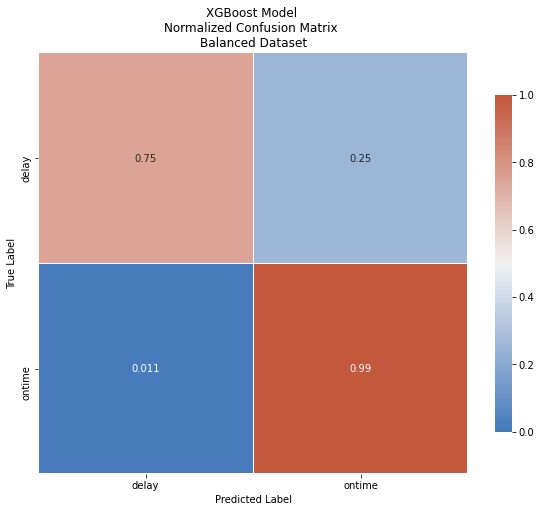

In [11]:
cm_neu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmtx = pd.DataFrame(cm_neu, 
                    index=['delay', 'ontime'], 
                    columns=['delay', 'ontime'])
print(cmtx)

# Plot heatmap for Confusion Matrix
plt.subplots(figsize=(8, 8)) 
heat_map = sb.heatmap(cmtx, cmap=cmap, annot=True, vmax=1, vmin=0, center=0.5, 
                      square=False, linewidths=.3, cbar_kws={"shrink": .8})
heat_map.figure.tight_layout()
heat_map.figure.subplots_adjust(bottom = 0.25)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('XGBoost Model \nNormalized Confusion Matrix \nBalanced Dataset')
plt.show()

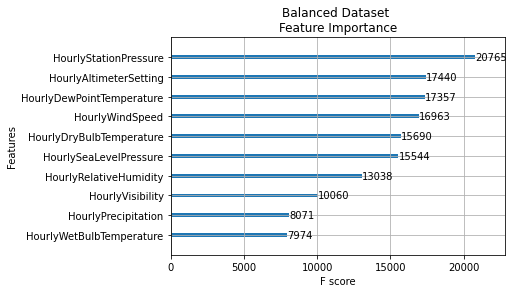

In [12]:
plot_importance(model)
plt.title('Balanced Dataset \nFeature Importance')
plt.show()